In [111]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [112]:
df = pd.read_csv('card_transaction.v1.csv')

In [113]:
# df.isnull().values.any()
# df.isnull().sum()

columns = df.drop(['Amount'], axis=1).columns
# columns = ['Time', 'Use Chip', 'Merchant City', 'Merchant State', 'Errors?', 'Is Fraud?']

for column in columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    
df['Amount'] = df['Amount'].replace({'\$': ''}, regex=True)

for columns in df.columns:
    df[columns] = df[columns].fillna(0)

# print(df.head())

transactions = df

transactions = MinMaxScaler().fit_transform(transactions)

In [114]:
class Sampling(layers.Layer):
  def call(self, inputs):
    mean, logvar = inputs
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(logvar * 0.5) + mean

class VAE(Model):
  def __init__(self):
    super(VAE, self).__init__()
    
    self.encoder = tf.keras.Sequential([
      # layers.Dense(15, activation="relu"),
      layers.Dense(7, activation="relu"),
      layers.Dense(2 + 2)
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(7, activation="relu"),
      layers.Dense(15, activation="relu"),
      # layers.Dense(30, activation="relu")
    ])
    
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  def reparameterize(self, mean, logvar):
    return Sampling()([mean, logvar])
  
  def decode(self, z):
    decoded = self.decoder(z)
    return decoded

  def call(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    decoded = self.decode(z)
    return decoded

vae = VAE()

vae.compile(optimizer='adam', loss='mae')

history = vae.fit(transactions, transactions,
                  epochs=50
                  ,
                  batch_size=64,
                  shuffle=True)

Epoch 1/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 40s 935us/step - loss: 0.1461
Epoch 2/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 37s 932us/step - loss: 0.1283
Epoch 3/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 36s 892us/step - loss: 0.1282
Epoch 4/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 36s 892us/step - loss: 0.1282
Epoch 5/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 35s 872us/step - loss: 0.1281
Epoch 6/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 38s 951us/step - loss: 0.1280
Epoch 7/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 0.1280
Epoch 8/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - loss: 0.1279
Epoch 9/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 0.1279
Epoch 10/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 0.1279
Epoch 11/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 0.1278
Epoch 12/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 0.1278
Epoch 13/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - loss: 0.1278
Epoch 14/50
39925/39925 ━━━━━━━━━━━━━━━━━━━━ 43s

In [115]:
# indices = np.random.choice(transactions.shape[0], size=200000, replace=False)
# transactions_sample = transactions[indices]

# reconstructions_sample = vae.predict(transactions_sample)

reconstructions = vae.predict(transactions)

79850/79850 ━━━━━━━━━━━━━━━━━━━━ 55s 690us/step


In [116]:
zeros = np.zeros((1, transactions.shape[1]))
ones = np.ones((1, transactions.shape[1]))

transactions = np.vstack((transactions, zeros, ones))
reconstructions = np.vstack((reconstructions, zeros, ones))

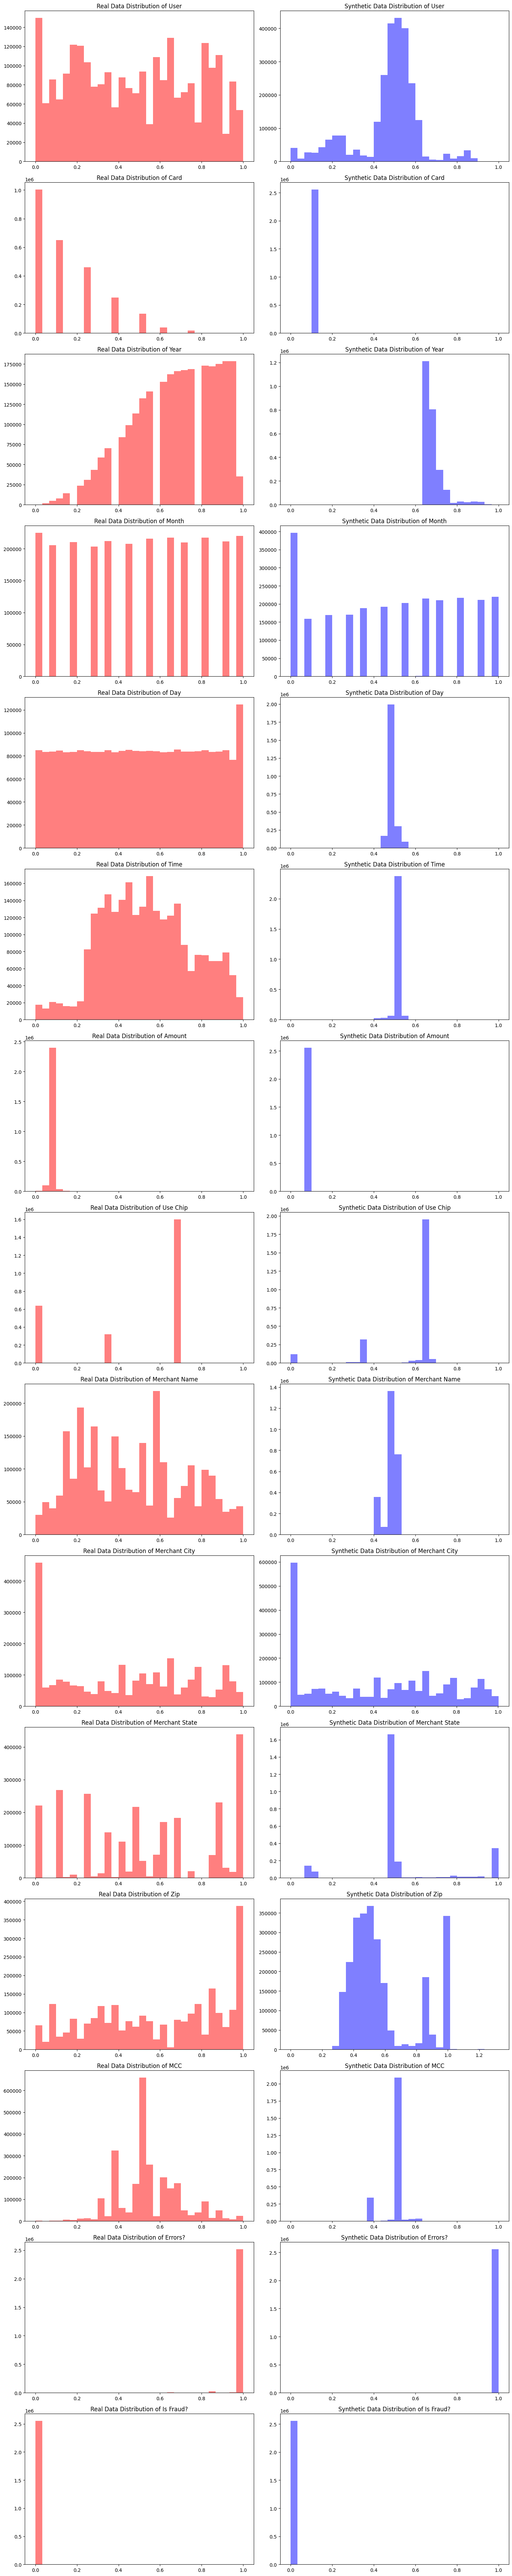

In [117]:
def evaluate_model(transactions, reconstructions):
    fig, ax = plt.subplots(transactions.shape[1], 2, figsize=(15, transactions.shape[1]*5))

    for i in range(transactions.shape[1]):
        ax[i, 0].hist(transactions[:, i], color='r', alpha=0.5, bins=30)
        ax[i, 1].hist(reconstructions[:, i], color='b', alpha=0.5, bins=30)
        # ax[i, 1].set_xlim([0, 1])
        ax[i, 0].set_title(f'Real Data Distribution of {df.columns[i]}')
        ax[i, 1].set_title(f'Synthetic Data Distribution of {df.columns[i]}')

    plt.tight_layout()
    plt.show()
    
evaluate_model(transactions, reconstructions)

In [119]:
total_data = np.vstack((transactions, reconstructions))

dup_total = len(total_data) - len(np.unique(total_data, axis=0))
dup_real = len(transactions) - len(np.unique(transactions, axis=0))
dup_synthetic = len(reconstructions) - len(np.unique(reconstructions, axis=0))

copies = dup_total - dup_real - dup_synthetic

print(f'% of data that is a direct copy of the real data: {copies / len(total_data) * 100:.2f}%')
print(f'% of data that is a self copy: {dup_synthetic / len(reconstructions) * 100:.2f}%')

% of data that is a direct copy of the real data: 0.00%
% of data that is a self copy: 0.07%
